# Basic Risk Frontier

Future enhancements:
- Consider trends and discounting

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
import sys
from pathlib import Path
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.exposure_base import RevenueExposure
from ergodic_insurance.insurance import InsurancePolicy, InsuranceLayer
from ergodic_insurance.simulation import Simulation, SimulationResults
from ergodic_insurance.ergodic_analyzer import ErgodicAnalyzer
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator
from ergodic_insurance.insurance_program import EnhancedInsuranceLayer, InsuranceProgram

## Define the Corporate Profile

In [2]:
INITIAL_ASSETS = 10_000_000
ASSET_TURNOVER_RATIO = 1.0  # Revenue = Assets × Turnover
EBITA_MARGIN_TARGET = 0.05  # EBITA after claims and insurance
DEDUCTIBLE = 50_000
LOSS_RATIO = 0.70

NUM_SIMULATIONS = 100
SIM_YEARS = 50

# Create manufacturer configuration
manufacturer_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,
    asset_turnover_ratio=ASSET_TURNOVER_RATIO,  # Revenue = Assets × Turnover
    base_operating_margin=0.10,  # EBITA before claims and insurance (need to calibrate)
    tax_rate=0.25,  # Current US Tax Rate
    retention_ratio=0.70,  # 30% dividends
    ppe_ratio=0.00,  # 0% of assets in PPE, so there is no depreciation expense
)

# Create widget manufacturer
base_manufacturer = WidgetManufacturer(manufacturer_config)

# Create exposure base based on revenue
exposure = RevenueExposure(state_provider=base_manufacturer)


## Define Losses

In [3]:
cur_revenue = base_manufacturer.total_assets * base_manufacturer.asset_turnover_ratio

# Calibrate claim generator for EBITA of 5%
target_ebita_margin = 0.05

generator = ManufacturingLossGenerator(
    attritional_params={
        'base_frequency': 2.85,
        'severity_mean': 40_000,
        'severity_cv': 0.8,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    large_params={
        'base_frequency': 0.20,
        'severity_mean': 500_000,
        'severity_cv': 1.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    catastrophic_params={
        'base_frequency': 0.02,
        'severity_xm': 5_000_000,
        'severity_alpha': 2.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    seed=42
)

In [ ]:
deductible = DEDUCTIBLE
policy_limit = 1_000_000_000


## Estimate Premium Assuming Perfect Distributional Knowledge

In [5]:
pricing_simulation_years = 500_000

total_insured_loss = 0.0
insured_loss_list = []

total_retained_loss = 0.0
retained_loss_list = []

for yr in range(pricing_simulation_years):
    loss_events, loss_meta = generator.generate_losses(duration=1, revenue=base_manufacturer.base_revenue)
    for loss_event in loss_events:
        insured_loss = max(min(loss_event.amount, policy_limit) - deductible,0)
        
        total_insured_loss += insured_loss
        insured_loss_list.append(insured_loss)

        retained_loss = loss_event.amount - insured_loss
        total_retained_loss += retained_loss
        retained_loss_list.append(retained_loss)

average_annual_insured_loss = total_insured_loss / pricing_simulation_years
average_annual_retained_loss = total_retained_loss / pricing_simulation_years
print(f"Average Annual Insured Loss: ${average_annual_insured_loss:,.0f}")
print(f"Average Annual Retained Loss: ${average_annual_retained_loss:,.0f}")

Average Annual Insured Loss: $276,508
Average Annual Retained Loss: $102,530


In [6]:
ground_up_losses = np.asarray(insured_loss_list, dtype=float) + np.asarray(retained_loss_list, dtype=float)
EXCESS_KURTOSIS = pd.Series(ground_up_losses).kurtosis()
print(f"Ground-Up Excess Kurtosis: {EXCESS_KURTOSIS:.2f}")

Ground-Up Excess Kurtosis: 3728.03


Total observations: 1,535,961
Zero (below deductible) count: 1,072,868 (69.8%)
Positive insured losses: 463,093
Mean positive loss: 298,544
Median positive loss: 28,866
95th percentile: 891,644
99th percentile: 6,852,111
Max loss (capped): 99,950,000


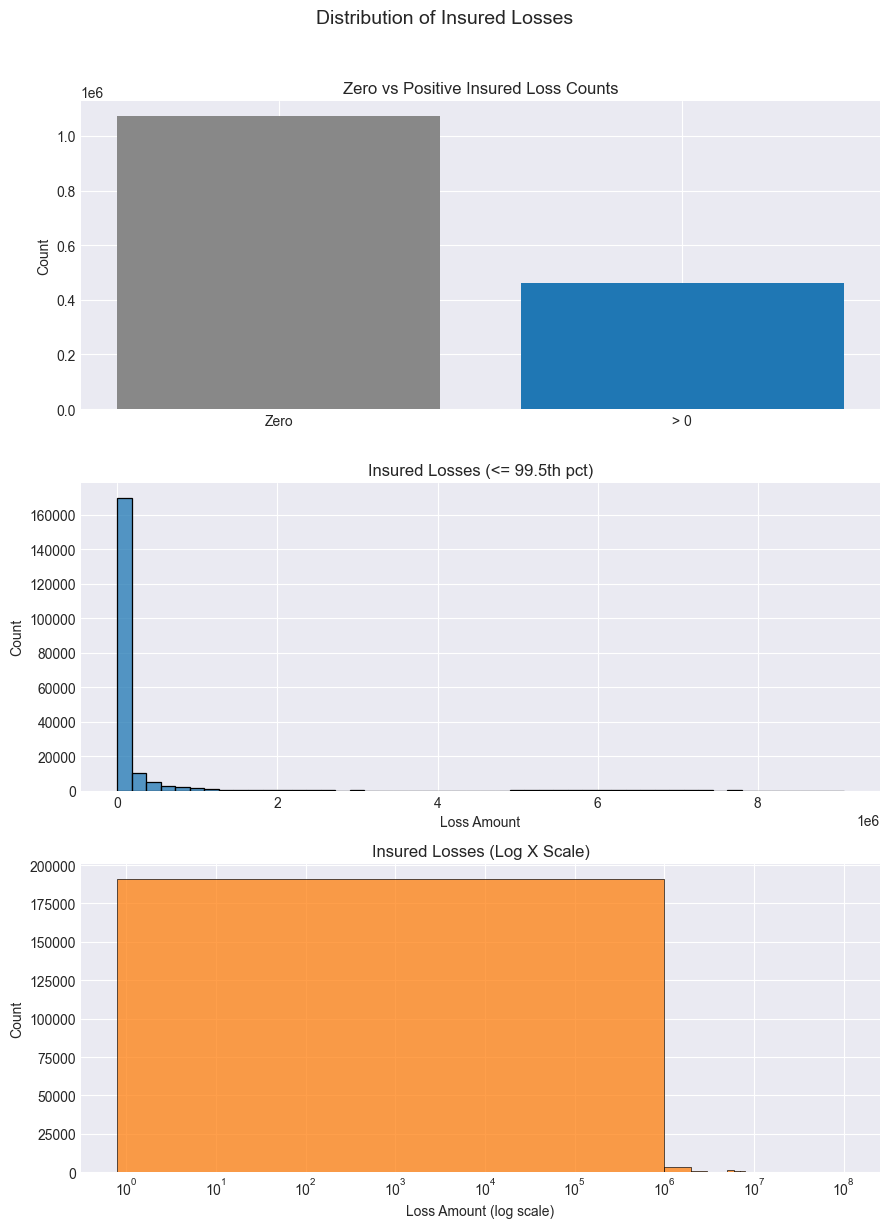

In [7]:
# Plot distribution of insured losses from loss_list

loss_array = np.asarray(insured_loss_list, dtype=float)

# Basic summary
zero_count = np.sum(loss_array == 0)
positive_losses = loss_array[loss_array > 0]
print(f"Total observations: {loss_array.size:,}")
print(f"Zero (below deductible) count: {zero_count:,} ({zero_count / loss_array.size:.1%})")
print(f"Positive insured losses: {positive_losses.size:,}")
if positive_losses.size:
    print(f"Mean positive loss: {positive_losses.mean():,.0f}")
    print(f"Median positive loss: {np.median(positive_losses):,.0f}")
    print(f"95th percentile: {np.percentile(positive_losses,95):,.0f}")
    print(f"99th percentile: {np.percentile(positive_losses,99):,.0f}")
    print(f"Max loss (capped): {positive_losses.max():,.0f}")

# Optional down-sample for plotting heavy tails
max_points = 200_000
if positive_losses.size > max_points:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(positive_losses.size, size=max_points, replace=False)
    plot_positive = positive_losses[sample_idx]
else:
    plot_positive = positive_losses

fig, axes = plt.subplots(3, 1, figsize=(9, 12))

# Zero vs positive
axes[0].bar(['Zero','> 0'], [zero_count, positive_losses.size], color=['#888','#1f77b4'])
axes[0].set_title('Zero vs Positive Insured Loss Counts')
axes[0].set_ylabel('Count')

# Histogram (linear scale, truncated upper tail to 99.5% for visibility)
if positive_losses.size:
    upper_cut = np.percentile(plot_positive, 99.5)
    sns.histplot(plot_positive[plot_positive <= upper_cut],
                 bins=50, ax=axes[1], color='#1f77b4')
    axes[1].set_title('Insured Losses (<= 99.5th pct)')
    axes[1].set_xlabel('Loss Amount')

# Histogram (log x scale for tail)
if positive_losses.size:
    sns.histplot(plot_positive, bins=100, ax=axes[2], color='#ff7f0e')
    axes[2].set_xscale('log')
    axes[2].set_title('Insured Losses (Log X Scale)')
    axes[2].set_xlabel('Loss Amount (log scale)')

fig.suptitle('Distribution of Insured Losses', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [8]:
loss_ratio = LOSS_RATIO

annual_premium = average_annual_insured_loss / loss_ratio
print(f"Annual Premium: ${annual_premium:,.0f}")

total_cost_of_risk = annual_premium + average_annual_retained_loss
print(f"Total Annual Cost of Risk: ${total_cost_of_risk:,.0f}")

Annual Premium: $395,011
Total Annual Cost of Risk: $497,541


In [9]:
cur_operating_income = base_manufacturer.calculate_operating_income(cur_revenue)

cur_net_income = base_manufacturer.calculate_net_income(
                    operating_income=cur_operating_income,
                    collateral_costs=0.0,
                    insurance_premiums=annual_premium,
                    insurance_losses=average_annual_retained_loss,
                    use_accrual=True,
                    time_resolution="annual",
                )

cur_net_income

376844.09802142094

In [10]:
target_net_income = base_manufacturer.base_revenue * target_ebita_margin * (1 - base_manufacturer.tax_rate)
target_net_income


375000.0

In [11]:
net_margin_diff = abs(cur_net_income - target_net_income) / cur_revenue

# assert net_margin_diff < 0.0005, f"Net income not within 0.05% of target ({net_margin_diff:.2%} difference)"

In [12]:
net_margin = cur_net_income / cur_revenue
print(f"Net Margin after insurance: {net_margin:.2%}")
print(f"EBITA Margin after insurance: {net_margin / (1 - base_manufacturer.tax_rate):.2%}")

Net Margin after insurance: 3.77%
EBITA Margin after insurance: 5.02%


## Define the Insurance Program

In [13]:

all_layers = EnhancedInsuranceLayer(
                attachment_point=deductible,
                limit=policy_limit,
                limit_type='per-occurrence',
                base_premium_rate=annual_premium / policy_limit
            )

program = InsuranceProgram([all_layers])

In [14]:
total_premium = program.calculate_annual_premium()
total_premium

np.float64(395010.77364881756)

## Begin the Study
- Run 50 years, repricing each time
  - Adjust premium appropriately to reflect loss costs
- Study results
- Set up additional parameters
- Study aggregate results and frontiers

### Define the Business Financials

In [15]:
# Create manufacturer configuration
manufacturer_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,
    asset_turnover_ratio=ASSET_TURNOVER_RATIO,  # Revenue = Assets × Turnover
    base_operating_margin=0.10,  # EBITA before claims and insurance (need to calibrate)
    tax_rate=0.25,  # Current US Tax Rate
    retention_ratio=0.70,  # 30% dividends
    ppe_ratio=0.00,  # 0% of assets in PPE, so there is no depreciation expense
)

# Create widget manufacturer
base_manufacturer = WidgetManufacturer(manufacturer_config)

# Create exposure base based on revenue
exposure = RevenueExposure(state_provider=base_manufacturer)

cur_revenue = base_manufacturer.total_assets * base_manufacturer.asset_turnover_ratio

# Calibrate claim generator for EBITA of 5%
target_ebita_margin = 0.05

generator = ManufacturingLossGenerator(
    attritional_params={
        'base_frequency': 2.85,
        'severity_mean': 40_000,
        'severity_cv': 0.8,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    large_params={
        'base_frequency': 0.20,
        'severity_mean': 500_000,
        'severity_cv': 1.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    catastrophic_params={
        'base_frequency': 0.02,
        'severity_xm': 5_000_000,
        'severity_alpha': 2.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    seed=42
)

deductible = 50_000
policy_limit = 40_000_000

pricing_simulation_years = 500_000

total_insured_loss = 0.0
insured_loss_list = []

total_retained_loss = 0.0
retained_loss_list = []

for yr in range(pricing_simulation_years):
    loss_events, loss_meta = generator.generate_losses(duration=1, revenue=base_manufacturer.base_revenue)
    for loss_event in loss_events:
        insured_loss = max(min(loss_event.amount, policy_limit) - deductible,0)
        
        total_insured_loss += insured_loss
        insured_loss_list.append(insured_loss)

        retained_loss = loss_event.amount - insured_loss
        total_retained_loss += retained_loss
        retained_loss_list.append(retained_loss)

average_annual_insured_loss = total_insured_loss / pricing_simulation_years
average_annual_retained_loss = total_retained_loss / pricing_simulation_years
print(f"Average Annual Insured Loss: ${average_annual_insured_loss:,.0f}")
print(f"Average Annual Retained Loss: ${average_annual_retained_loss:,.0f}")

loss_ratio = 0.70

annual_premium = average_annual_insured_loss / loss_ratio
print(f"Annual Premium: ${annual_premium:,.0f}")

total_cost_of_risk = annual_premium + average_annual_retained_loss
print(f"Total Annual Cost of Risk: ${total_cost_of_risk:,.0f}")

cur_operating_income = base_manufacturer.calculate_operating_income(cur_revenue)

cur_net_income = base_manufacturer.calculate_net_income(
                    operating_income=cur_operating_income,
                    collateral_costs=0.0,
                    insurance_premiums=annual_premium,
                    insurance_losses=average_annual_retained_loss,
                    use_accrual=True,
                    time_resolution="annual",
                )

cur_net_income

target_net_income = base_manufacturer.base_revenue * target_ebita_margin * (1 - base_manufacturer.tax_rate)
target_net_income

net_margin_diff = abs(cur_net_income - target_net_income) / cur_revenue

# assert net_margin_diff < 0.0005, f"Net income not within 0.05% of target ({net_margin_diff:.2%} difference)"

net_margin = cur_net_income / cur_revenue
print(f"Net Margin after insurance: {net_margin:.2%}")
print(f"EBITA Margin after insurance: {net_margin / (1 - base_manufacturer.tax_rate):.2%}")

Average Annual Insured Loss: $274,793
Average Annual Retained Loss: $104,245
Annual Premium: $392,561
Total Annual Cost of Risk: $496,806
Net Margin after insurance: 3.77%
EBITA Margin after insurance: 5.03%


### Define the Insurance Program

In [16]:
from ergodic_insurance.insurance_pricing import InsurancePricer, PricingParameters

policy_pricer = InsurancePricer(loss_generator=generator,
                                loss_ratio=loss_ratio,
                                parameters=PricingParameters(
                                    loss_ratio=loss_ratio,
                                    simulation_years=100_000
                                    )
                                )

all_layers = EnhancedInsuranceLayer(
                attachment_point=deductible,
                limit=policy_limit,
                limit_type='per-occurrence',
                base_premium_rate=annual_premium / policy_limit  # Use small premium
            )

program = InsuranceProgram([all_layers],
                            pricing_enabled=True,
                            pricer=policy_pricer)

total_premium = program.calculate_annual_premium()
print(f"Total Program Premium: ${total_premium:,.2f}")

# The assertion should check against the small premium
assert abs(total_premium - annual_premium) < 1.0, f"Calculated premium ({total_premium:,.0f}) does not match target premium ({annual_premium:,.0f})"

Total Program Premium: $392,560.96


## Set Up the Simulation

In [17]:
from ergodic_insurance.monte_carlo import MonteCarloEngine, SimulationConfig, SimulationResults

def setup_simulation_engine(n_simulations=10_000, n_years=10, parallel=False, insurance_program=None):
    """Set up Monte Carlo simulation engine."""
    # Create simulation config
    config = SimulationConfig(
        n_simulations=n_simulations,
        n_years=n_years,
        n_chains=4,
        parallel=parallel,
        n_workers=None,
        chunk_size=max(1000, n_simulations // 10),
        use_float32=True,
        cache_results=False,
        progress_bar=True,
        ruin_evaluation=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        working_capital_pct=0.0,  # Set working capital to 0% for full asset revenue generation
        seed=42
    )
    
    if insurance_program is None:
        insurance_program = InsuranceProgram(
                                layers=[],  # Empty list to define no coverage
                                deductible=0.0,  # No deductible needed since all losses are retained
                                pricer=None,
                                name="No Insurance"
                            )

    # Create engine
    engine = MonteCarloEngine(
        loss_generator=generator,
        insurance_program=insurance_program,
        manufacturer=base_manufacturer,
        config=config
    )
    
    return engine

# Create engine
print("Setting up Monte Carlo engine with Insurance...")
engine = setup_simulation_engine(n_simulations=NUM_SIMULATIONS, n_years=SIM_YEARS, parallel=False, insurance_program=program)
print(f"Engine configured: {engine.config.n_simulations:,} simulations, {engine.config.n_years} years")
print(f"Parallel processing: {engine.config.parallel}")
print(f"Number of chains: {engine.config.n_chains}")
print(f"Deductible: {engine.insurance_program.deductible}")

Setting up Monte Carlo engine with Insurance...
Engine configured: 100 simulations, 50 years
Parallel processing: False
Number of chains: 4
Deductible: 0.0


### Set Up the Simulation Without Insurance

In [18]:
# Create engine without insurance
print("Setting up Monte Carlo engine without Insurance...")
engine_no_ins = setup_simulation_engine(n_simulations=NUM_SIMULATIONS, n_years=SIM_YEARS, parallel=False, insurance_program=None)
print(f"Engine configured: {engine_no_ins.config.n_simulations:,} simulations, {engine_no_ins.config.n_years} years")
print(f"Parallel processing: {engine_no_ins.config.parallel}")
print(f"Number of chains: {engine_no_ins.config.n_chains}")
print(f"Deductible: {engine_no_ins.insurance_program.deductible}")

Setting up Monte Carlo engine without Insurance...
Engine configured: 100 simulations, 50 years
Parallel processing: False
Number of chains: 4
Deductible: 0.0


## Run the Simulation

In [19]:
results = engine.run()
results_no_ins = engine_no_ins.run()

Running simulations:  16%|█▌        | 16/100 [00:00<00:01, 74.82it/s]Company became insolvent - negative equity: $-1,099,515.09
Company became insolvent - negative equity: $-171,549.68
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Company is already insolvent, skipping step
Running simulations:  87%|████████▋ | 87/100 [00:01<00:00, 56.85it/s]Company became insolvent - negative equity: $-1,328,002.85
Company became insolvent - negative equity: $-21,387,477.50
Company became insolvent - negative equity: $-1,983,011.19
Running simulations: 100%|██████████| 100/100 [00:01<00:00, 56.80it/s]


In [20]:
import pickle

filename = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt ({EXCESS_KURTOSIS:.0f}) -\
 Ded ({DEDUCTIBLE/1_000:.0f}K) -\
 LR ({LOSS_RATIO}) -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs.pkl"

with open(filename, "wb") as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
filename_no_ins = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt ({EXCESS_KURTOSIS:.0f}) -\
 NOINS -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs.pkl"

with open(filename_no_ins, "wb") as f:
    pickle.dump(results_no_ins, f, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
print(results.summary())

Simulation Results Summary
Simulations: 100
Years: 50
Execution Time: 2.15s
Ruin Probability:
  Year 5: 0.00%
  Year 10: 0.00%
  Year 15: 0.00%
  Year 20: 0.00%
  Year 25: 0.00%
  Year 30: 1.00%
  Year 35: 1.00%
  Year 40: 1.00%
  Year 45: 1.00%
  Year 50: 1.00%
Mean Final Assets: $22,213,594
Mean Growth Rate: 0.0160
VaR(99%): $79,260,320
TVaR(99%): $81,898,408
Convergence R-hat: 0.000

Performance Summary
Total Time: 2.15s
Setup: 0.00s
Computation: 2.15s
Serialization: 0.00s (0.0% overhead)
Reduction: 0.00s
Peak Memory: 0.2 MB
CPU Utilization: 0.0%
Throughput: 46 items/s
Speedup: 1.00x

Advanced Aggregation Results:
  p1: $8,352,220
  p5: $22,571,765
  p10: $22,581,505
  p25: $22,589,243
  p50: $22,605,922
  p75: $22,633,693
  p90: $22,653,001
  p95: $22,664,903
  p99: $22,694,485



In [23]:
print(results_no_ins.summary())

Simulation Results Summary
Simulations: 100
Years: 50
Execution Time: 1.95s
Ruin Probability:
  Year 5: 0.00%
  Year 10: 0.00%
  Year 15: 2.00%
  Year 20: 4.00%
  Year 25: 5.00%
  Year 30: 7.00%
  Year 35: 7.00%
  Year 40: 7.00%
  Year 45: 7.00%
  Year 50: 7.00%
Mean Final Assets: $14,973,185
Mean Growth Rate: 0.0058
VaR(99%): $46,850,932
TVaR(99%): $62,848,100
Convergence R-hat: 0.000

Performance Summary
Total Time: 1.95s
Setup: 0.00s
Computation: 1.95s
Serialization: 0.00s (0.0% overhead)
Reduction: 0.00s
Peak Memory: 0.2 MB
CPU Utilization: 0.0%
Throughput: 51 items/s
Speedup: 1.00x

Advanced Aggregation Results:
  p1: $-2,869,271
  p5: $-452,239
  p10: $2,290,599
  p25: $9,548,861
  p50: $15,815,917
  p75: $21,805,146
  p90: $27,382,373
  p95: $28,417,906
  p99: $30,449,039



In [24]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
import sys
from pathlib import Path
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.exposure_base import RevenueExposure
from ergodic_insurance.insurance import InsurancePolicy, InsuranceLayer
from ergodic_insurance.simulation import Simulation, SimulationResults
from ergodic_insurance.ergodic_analyzer import ErgodicAnalyzer
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator
from ergodic_insurance.insurance_program import EnhancedInsuranceLayer, InsuranceProgram

# Read the specified pickle file (tries results/ directory first)
results_filename = "Cap (10M) - ATR (1.0) - EBITA (0.05) - XS_Kurt (3728) - Ded (50K) - LR (0.7).pkl"

candidate_paths = [Path("results") / results_filename, Path(results_filename)]

if results is None:
    for p in candidate_paths:
        if p.exists():
            with open(p, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded pickle from: {p}")
            break

    if results is None:
        print(f"File not found in: {[str(p) for p in candidate_paths]}")
    else:
        # If this is a SimulationResults object, show a brief summary
        if hasattr(results, "summary"):
            try:
                print(results.summary())
            except Exception as e:
                print(f"Could not print summary: {e}")
        else:
            print(f"Loaded object type: {type(results)}")
else:
    print("Results with insurance already loaded.")

# Read the specified pickle file (tries results/ directory first)
results_no_ins_filename = "Cap (10M) - ATR (1.0) - EBITA (0.05) - XS_Kurt (3728) - NOINS.pkl"

candidate_paths = [Path("results") / results_no_ins_filename, Path(results_no_ins_filename)]

if results_no_ins is None:
    for p in candidate_paths:
        if p.exists():
            with open(p, "rb") as f:
                results_no_ins = pickle.load(f)
            print(f"Loaded pickle from: {p}")
            break

    if results_no_ins is None:
        print(f"File not found in: {[str(p) for p in candidate_paths]}")
    else:
        # If this is a SimulationResults object, show a brief summary
        if hasattr(results_no_ins, "summary"):
            try:
                print(results_no_ins.summary())
            except Exception as e:
                print(f"Could not print summary: {e}")
        else:
            print(f"Loaded object type: {type(results_no_ins)}")
else:
    print("Results without insurance already loaded.")

Results with insurance already loaded.
Results without insurance already loaded.


In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ergodic_insurance.visualization.core import WSJ_COLORS
import numpy as np

# Print results
print(f"\nRuin Probabilities by Time Horizon:")
for yr, prob in results.ruin_probability.items():
    print(f"  {yr} years: {prob*100:.2f}%")

print(f"\nConvergence achieved: {'Yes' if results.convergence else 'No'}")

# --------------------------------------
# Time-Average Growth Rate Histogram (1,1)
# --------------------------------------
fig = go.Figure()

# Growth rates with insurance
growth_rates = np.asarray(results.growth_rates, dtype=float)
growth_rates = growth_rates[np.isfinite(growth_rates)]

# Growth rates without insurance
growth_rates_no_ins = np.asarray(results_no_ins.growth_rates, dtype=float)
growth_rates_no_ins = growth_rates_no_ins[np.isfinite(growth_rates_no_ins)]

growth_pct = growth_rates * 100.0
mean_growth = np.nanmean(growth_pct)
median_growth = np.nanmedian(growth_pct)
p5, p25, p95 = np.nanpercentile(growth_pct, [5, 25, 95])
print(f"Growth Rate Summary With Insurance (%): Mean={mean_growth:.2f}, Median={median_growth:.2f}, 25th={p25:.2f}, 5th={p5:.2f}")

growth_pct_no_ins = growth_rates_no_ins * 100.0
mean_growth_no_ins = np.nanmean(growth_pct_no_ins)
median_growth_no_ins = np.nanmedian(growth_pct_no_ins)
p5_no_ins, p25_no_ins, p95_no_ins = np.nanpercentile(growth_pct_no_ins, [5, 25, 95])
print(f"Growth Rate Summary Without Insurance (%): Mean={mean_growth_no_ins:.2f}, Median={median_growth_no_ins:.2f}, 25th={p25_no_ins:.2f}, 5th={p5_no_ins:.2f}")

# Plot Growth Rate With Insurance
# Kernel Density Estimate (Gaussian) instead of histogram
xs = np.linspace(growth_pct.min(), growth_pct.max(), 400)
n = growth_pct.size
std = np.std(growth_pct, ddof=1)
if std == 0 or n < 2:
    # Fallback: flat line at 0
    density = np.zeros_like(xs)
else:
    bw = 1.06 * std * n ** (-1/5)  # Silverman's rule
    inv_norm = 1.0 / (bw * np.sqrt(2 * np.pi))
    diffs = (xs[:, None] - growth_pct[None, :]) / bw
    density = inv_norm * np.exp(-0.5 * diffs**2).mean(axis=1)

fig.add_trace(
    go.Scatter(
        x=xs,
        y=density,
        mode='lines',
        name='Insurance',
        line=dict(color=WSJ_COLORS.get('blue', '#1f77b4'), width=2)
    )
)

# Plot Growth Rate Without Insurance
# Kernel Density Estimate (Gaussian) instead of histogram
xs_no_ins = np.linspace(growth_pct_no_ins.min(), growth_pct_no_ins.max(), 400)
n_no_ins = growth_pct_no_ins.size
std_no_ins = np.std(growth_pct_no_ins, ddof=1)
if std_no_ins == 0 or n_no_ins < 2:
    # Fallback: flat line at 0
    density = np.zeros_like(xs_no_ins)
else:
    bw = 1.06 * std_no_ins * n_no_ins ** (-1/5)  # Silverman's rule
    inv_norm_no_ins = 1.0 / (bw * np.sqrt(2 * np.pi))
    diffs_no_ins = (xs_no_ins[:, None] - growth_pct_no_ins[None, :]) / bw
    density_no_ins = inv_norm_no_ins * np.exp(-0.5 * diffs_no_ins**2).mean(axis=1)

# Set x-axis to central 99.5% of both distributions (trim 0.25% each tail)
try:
    lower_q, upper_q = .5, 99.5
    lo_ins, hi_ins = np.nanpercentile(growth_pct, [lower_q, upper_q])
    lo_no_ins, hi_no_ins = np.nanpercentile(growth_pct_no_ins, [lower_q, upper_q])
    x_min = min(lo_ins, lo_no_ins)
    x_max = max(hi_ins, hi_no_ins)
    pad = 0.01 * (x_max - x_min) if x_max > x_min else 0.0
    fig.update_xaxes(range=[x_min - pad, x_max + pad])
except Exception as e:
    print(f"Could not apply 99.5% central x-range: {e}")

# Adjust y-axis label to reflect density
fig.update_yaxes(title_text="Density")

# Recompute KDEs on clipped range [-10, 5] and update plot
lower, upper = -5.0, 5.0
# Clear existing traces, shapes, annotations
fig.data = ()
fig.layout.shapes = ()
fig.layout.annotations = ()

# Clip datasets
ins_clip = growth_pct[(growth_pct >= lower) & (growth_pct <= upper)]
no_ins_clip = growth_pct_no_ins[(growth_pct_no_ins >= lower) & (growth_pct_no_ins <= upper)]

xs_clip = np.linspace(lower, upper, 400)

def kde(arr, xs):
    n = arr.size
    if n < 2:
        return np.zeros_like(xs)
    std_ = np.std(arr, ddof=1)
    if std_ == 0:
        return np.zeros_like(xs)
    bw = 1.06 * std_ * n ** (-1/5)
    inv = 1.0 / (bw * np.sqrt(2 * np.pi))
    diffs = (xs[:, None] - arr[None, :]) / bw
    return inv * np.exp(-0.5 * diffs**2).mean(axis=1)

dens_ins = kde(ins_clip, xs_clip) if ins_clip.size else np.zeros_like(xs_clip)
dens_no  = kde(no_ins_clip, xs_clip) if no_ins_clip.size else np.zeros_like(xs_clip)

# Add traces
fig.add_trace(go.Scatter(
    x=xs_clip, y=dens_ins, mode='lines', name='Insurance (clipped)',
    line=dict(color=WSJ_COLORS.get('blue', '#1f77b4'), width=2)
))
fig.add_trace(go.Scatter(
    x=xs_clip, y=dens_no, mode='lines', name='No Insurance (clipped)',
    line=dict(color=WSJ_COLORS.get('orange', '#ff7f0e'), width=2)
))

# Stats on clipped data
if ins_clip.size:
    mean_ins = np.nanmean(ins_clip)
    p25_ins = np.nanpercentile(ins_clip, 25)
    # Add vertical lines for mean and median
    fig.add_vline(x=mean_ins, 
                line_dash='dash', 
                line_color=WSJ_COLORS.get('blue', '#1f77b4'), 
                annotation_text='Mean (Ins)', 
                annotation_position='top right')
    fig.add_vline(x=p25_ins, 
                line_dash='dot', 
                line_color=WSJ_COLORS.get('red', '#d62728'), 
                annotation_text='25th pct (Ins)', 
                annotation_position='top left')
if no_ins_clip.size:
    mean_no = np.nanmean(no_ins_clip)
    p25_no = np.nanpercentile(no_ins_clip, 25)
    # Add vertical lines for mean and median
    fig.add_vline(x=mean_no, 
                line_dash='dash', 
                line_color=WSJ_COLORS.get('orange', '#ff7f0e'), 
                annotation_text='Mean (No Ins)', 
                annotation_position='bottom right')
    fig.add_vline(x=p25_no, 
                line_dash='dot', 
                line_color=WSJ_COLORS.get('red', '#d62728'),
                annotation_text='25th pct (No Ins)', 
                annotation_position='bottom left')


# Update layout
fig.update_layout(
    title={
        "text": "Time-Average Growth Rate Histogram",
        "x": 0.5,
        "xanchor": "center"
    },
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.2,
        yanchor='top'
    ),
    width=800,
    height=500
)

# Axes titles
fig.update_xaxes(title_text="Time-Average Growth Rate (%)",
                range=[lower, upper])

fig.show()


Ruin Probabilities by Time Horizon:
  5 years: 0.00%
  10 years: 0.00%
  15 years: 0.00%
  20 years: 0.00%
  25 years: 0.00%
  30 years: 1.00%
  35 years: 1.00%
  40 years: 1.00%
  45 years: 1.00%
  50 years: 1.00%

Convergence achieved: No
Growth Rate Summary With Insurance (%): Mean=1.60, Median=1.63, 25th=1.63, 5th=1.63
Growth Rate Summary Without Insurance (%): Mean=0.58, Median=0.92, 25th=0.00, 5th=-2.54


In [26]:
import plotly.io as pio

fig_filename = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt (high) -\
 Ded ({DEDUCTIBLE/1_000:.0f}K) -\
 LR ({LOSS_RATIO}) -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs - Growth Rate.png"

pio.write_image(fig, fig_filename, scale=2) # Adjust scale as needed

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ergodic_insurance.visualization.core import WSJ_COLORS
import numpy as np

# Print results
print(f"\nRuin Probabilities by Time Horizon:")
for yr, prob in results.ruin_probability.items():
    print(f"  {yr} years: {prob*100:.2f}%")

print(f"\nConvergence achieved: {'Yes' if results.convergence else 'No'}")

# --------------------------------------
# Ruin probability comparison (1,2)
# --------------------------------------
# Single figure without subplots
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(results.ruin_probability.keys()),
        y=[prob * 100 for prob in results.ruin_probability.values()],
        mode='lines+markers',
        name='Insurance',
        line=dict(width=2, color=WSJ_COLORS.get('blue', '#1f77b4')),
        marker=dict(size=8)
    )
)
fig.add_trace(
    go.Scatter(
        x=list(results_no_ins.ruin_probability.keys()),
        y=[prob * 100 for prob in results_no_ins.ruin_probability.values()],
        mode='lines+markers',
        name='No Insurance',
        line=dict(width=2, color=WSJ_COLORS.get('orange', '#ff7f0e')),
        marker=dict(size=8)
    )
)

# Update layout
fig.update_layout(
    title={
        "text": "Ruin Probability by Time Horizon",
        "x": 0.5,
        "xanchor": "center"
    },
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.2,
        yanchor='top'
    ),
    width=800,
    height=500
)

# Axes titles
fig.update_xaxes(title_text="Time Horizon (years)")
fig.update_yaxes(title_text="Ruin Probability (%)")

fig.show()


Ruin Probabilities by Time Horizon:
  5 years: 0.00%
  10 years: 0.00%
  15 years: 0.00%
  20 years: 0.00%
  25 years: 0.00%
  30 years: 1.00%
  35 years: 1.00%
  40 years: 1.00%
  45 years: 1.00%
  50 years: 1.00%

Convergence achieved: No


In [28]:
fig_filename = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt (high) -\
 Ded ({DEDUCTIBLE/1_000:.0f}K) -\
 LR ({LOSS_RATIO}) -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs - RoR.png"

pio.write_image(fig, fig_filename, scale=2) # Adjust scale as needed

In [29]:
print(f'Final net asset value with insurance: ${results.final_assets.mean():,.0f} ± ${results.final_assets.std():,.0f}')
print(f'Final net asset value without insurance: ${results_no_ins.final_assets.mean():,.0f} ± ${results_no_ins.final_assets.std():,.0f}')

Final net asset value with insurance: $22,213,594 ± $2,921,140
Final net asset value without insurance: $14,973,185 ± $9,271,236


In [30]:
print(f"Parallel: {engine.config.parallel}")
print(f"Use enhanced parallel: {engine.config.use_enhanced_parallel}")

# Check which path would be taken
if engine.config.parallel:
    if engine.config.use_enhanced_parallel:
        print("Would use: _run_enhanced_parallel() -> _simulate_path_enhanced")
    else:
        print("Would use: _run_parallel()")
else:
    print("Would use: _run_sequential() -> _run_single_simulation")

Parallel: False
Use enhanced parallel: True
Would use: _run_sequential() -> _run_single_simulation


In [31]:
# Force reload of the module again to get all fixes
import importlib
import sys

# Force reload of the monte_carlo module
if 'ergodic_insurance.monte_carlo' in sys.modules:
    del sys.modules['ergodic_insurance.monte_carlo']
if 'ergodic_insurance.manufacturer' in sys.modules:
    del sys.modules['ergodic_insurance.manufacturer']

from ergodic_insurance.monte_carlo import MonteCarloEngine
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.config import ManufacturerConfig

# Recreate the simulation setup with fresh imports
manufacturer_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,
    asset_turnover_ratio=ASSET_TURNOVER_RATIO,
    base_operating_margin=0.10,
    tax_rate=0.25,
    retention_ratio=0.70,
    ppe_ratio=0.00,
)
base_manufacturer = WidgetManufacturer(manufacturer_config)

# Run a test simulation with the comprehensive fixes
print("Running test simulation with all fixes...")
engine_test2 = setup_simulation_engine(n_simulations=100, n_years=10, parallel=False, insurance_program=program)

# Check the config
print(f"Config - Parallel: {engine_test2.config.parallel}")
print(f"Config - Enhanced: {engine_test2.config.use_enhanced_parallel}")
print(f"Config - Working Capital: {engine_test2.config.working_capital_pct}")

results_test2 = engine_test2.run()

print(f"\n=== Results with All Fixes ===")
print(f"Average growth rate: {np.mean(results_test2.growth_rates)*100:.2f}%")
print(f"Median growth rate: {np.median(results_test2.growth_rates)*100:.2f}%")
print(f"Mean final assets: ${results_test2.final_assets.mean():,.0f}")
print(f"Expected theoretical growth: {theoretical_growth:.2%}")
print(f"Gap from theoretical: {(np.mean(results_test2.growth_rates) - theoretical_growth)*100:.2f} percentage points")

Running test simulation with all fixes...
Config - Parallel: False
Config - Enhanced: True
Config - Working Capital: 0.0


Running simulations: 100%|██████████| 100/100 [00:00<00:00, 227.42it/s]



=== Results with All Fixes ===
Average growth rate: 1.83%
Median growth rate: 1.82%
Mean final assets: $12,003,491


NameError: name 'theoretical_growth' is not defined

In [ ]:
# Recalculate theoretical growth
theoretical_growth = 0.0503 * (1 - 0.25) * 0.70  # EBITDA * (1-tax) * retention
print(f"Expected theoretical growth: {theoretical_growth:.2%}")
print(f"Gap from theoretical: {(np.mean(results_test2.growth_rates) - theoretical_growth)*100:.2f} percentage points")

# Let's trace through a single simulation to see what's happening
print("\n=== Detailed Single Path Analysis ===")

# Create a fresh manufacturer
test_mfr = WidgetManufacturer(manufacturer_config)
print(f"Initial assets: ${test_mfr.total_assets:,.0f}")

# Simulate one year manually
test_mfr.record_insurance_premium(annual_premium)
test_mfr.record_insurance_loss(average_annual_retained_loss)

# Step
metrics = test_mfr.step(working_capital_pct=0.0)

print(f"\nAfter Year 1:")
print(f"Revenue: ${metrics['revenue']:,.0f}")
print(f"Operating Income: ${metrics['operating_income']:,.0f}")
print(f"Net Income: ${metrics['net_income']:,.0f}")
print(f"Assets: ${test_mfr.total_assets:,.0f}")
print(f"Growth: {(test_mfr.total_assets - INITIAL_ASSETS)/INITIAL_ASSETS:.2%}")

# Check what the insurance costs were
print(f"\nInsurance costs recorded:")
print(f"Premium: ${metrics['insurance_premiums']:,.0f}")
print(f"Losses: ${metrics['insurance_losses']:,.0f}")
print(f"Total: ${metrics['total_insurance_costs']:,.0f}")

In [32]:
# Let's check if we're still getting the lower growth rate in the notebook
# Re-run the simulation with the fixed code

# First, verify the theoretical calculation
ebita_margin = 0.0503
tax_rate = 0.25
retention_ratio = 0.70
theoretical_growth = ebita_margin * (1 - tax_rate) * retention_ratio
print(f"Theoretical annual growth rate: {theoretical_growth:.2%}")

# Now run a fresh simulation
print("\nRunning simulation after fixes...")
engine_fresh = setup_simulation_engine(n_simulations=100, n_years=10, parallel=False, insurance_program=program)
results_fresh = engine_fresh.run()

print(f"\nResults:")
print(f"Mean growth rate: {np.mean(results_fresh.growth_rates)*100:.2f}%")
print(f"Theoretical growth: {theoretical_growth*100:.2f}%")
print(f"Ergodicity gap: {(theoretical_growth - np.mean(results_fresh.growth_rates))*100:.2f} percentage points")

# Check if there's volatility causing the gap
print(f"\nGrowth rate std dev: {np.std(results_fresh.growth_rates)*100:.2f}%")

final_assets_avg = results_fresh.final_assets.mean()
simple_growth = (final_assets_avg / INITIAL_ASSETS)**(1/10) - 1
print(f"Simple average growth from assets: {simple_growth*100:.2f}%")

Theoretical annual growth rate: 2.64%

Running simulation after fixes...


Running simulations: 100%|██████████| 100/100 [00:00<00:00, 305.54it/s]



Results:
Mean growth rate: 1.82%
Theoretical growth: 2.64%
Ergodicity gap: 0.82 percentage points

Growth rate std dev: 0.01%
Simple average growth from assets: 1.84%


In [33]:
# Let's trace through one year more carefully
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.config import ManufacturerConfig

# Create a test manufacturer
test_config = ManufacturerConfig(
    initial_assets=10_000_000,
    asset_turnover_ratio=1.0,
    base_operating_margin=0.10,
    tax_rate=0.25,
    retention_ratio=0.70,
    ppe_ratio=0.00,
)
mfr = WidgetManufacturer(test_config)

print("=== Initial State ===")
print(f"Assets: ${mfr.total_assets:,.0f}")
print(f"Cash: ${mfr.cash:,.0f}")

# Now simulate what happens in one year

# Step 1: Calculate revenue (should be 10M with no working capital)
revenue = mfr.calculate_revenue(working_capital_pct=0.0)
print(f"\nRevenue calculated: ${revenue:,.0f}")

# Step 2: Record insurance costs (what the simulation does)
mfr.record_insurance_premium(392_561)  # From earlier calculation
mfr.record_insurance_loss(104_245)    # Average retained loss
print(f"Recorded premium: ${392_561:,.0f}")
print(f"Recorded loss: ${104_245:,.0f}")

# Step 3: Calculate operating income manually
base_operating_income = revenue * mfr.base_operating_margin
actual_operating_income = base_operating_income - mfr.period_insurance_premiums - mfr.period_insurance_losses
print(f"\nBase operating income (10% margin): ${base_operating_income:,.0f}")
print(f"Less insurance costs: ${mfr.period_insurance_premiums + mfr.period_insurance_losses:,.0f}")
print(f"Actual operating income: ${actual_operating_income:,.0f}")

# Step 4: Calculate net income
tax = actual_operating_income * mfr.tax_rate
net_income = actual_operating_income - tax
print(f"\nTax (25%): ${tax:,.0f}")
print(f"Net income: ${net_income:,.0f}")

# Step 5: Calculate retained earnings
retained_earnings = net_income * mfr.retention_ratio
print(f"\nRetained earnings (70% retention): ${retained_earnings:,.0f}")

# Step 6: Expected new assets
expected_assets = mfr.total_assets + retained_earnings
print(f"\nExpected assets after retention: ${expected_assets:,.0f}")
print(f"Expected growth: {retained_earnings/mfr.total_assets:.2%}")

=== Initial State ===
Assets: $10,000,000
Cash: $10,000,000

Revenue calculated: $10,000,000
Recorded premium: $392,561
Recorded loss: $104,245

Base operating income (10% margin): $1,000,000
Less insurance costs: $496,806
Actual operating income: $503,194

Tax (25%): $125,798
Net income: $377,396

Retained earnings (70% retention): $264,177

Expected assets after retention: $10,264,177
Expected growth: 2.64%


In [34]:
# Now let's see what happens when we actually run the step() method
mfr2 = WidgetManufacturer(test_config)

print("=== Running actual step() method ===")
print(f"Initial assets: ${mfr2.total_assets:,.0f}")

# Record insurance costs
mfr2.record_insurance_premium(392_561)
mfr2.record_insurance_loss(104_245)

# Run step
metrics = mfr2.step(working_capital_pct=0.0)

print(f"\nAfter step:")
print(f"Final assets: ${mfr2.total_assets:,.0f}")
print(f"Actual growth: {(mfr2.total_assets - 10_000_000)/10_000_000:.2%}")

# Check the metrics
print(f"\nMetrics from step:")
print(f"Revenue: ${metrics['revenue']:,.0f}")
print(f"Operating income: ${metrics['operating_income']:,.0f}")
print(f"Net income: ${metrics['net_income']:,.0f}")
print(f"Insurance premiums: ${metrics['insurance_premiums']:,.0f}")
print(f"Insurance losses: ${metrics['insurance_losses']:,.0f}")

# Now simulate a second year
print("\n=== Year 2 ===")
initial_year2 = mfr2.total_assets

# The simulation would scale the insurance costs
revenue_year2 = mfr2.calculate_revenue(working_capital_pct=0.0)
scaling_factor = revenue_year2 / 10_000_000
scaled_premium = 392_561 * scaling_factor
scaled_loss = 104_245 * scaling_factor

print(f"Starting assets: ${initial_year2:,.0f}")
print(f"Revenue: ${revenue_year2:,.0f}")
print(f"Scaling factor: {scaling_factor:.4f}")
print(f"Scaled premium: ${scaled_premium:,.0f}")
print(f"Scaled loss: ${scaled_loss:,.0f}")

mfr2.record_insurance_premium(scaled_premium)
mfr2.record_insurance_loss(scaled_loss)
metrics2 = mfr2.step(working_capital_pct=0.0)

print(f"\nAfter year 2:")
print(f"Final assets: ${mfr2.total_assets:,.0f}")
print(f"Year 2 growth: {(mfr2.total_assets - initial_year2)/initial_year2:.2%}")
print(f"Cumulative growth rate: {((mfr2.total_assets/10_000_000)**(1/2) - 1):.2%}")

=== Running actual step() method ===
Initial assets: $10,000,000

After step:
Final assets: $10,264,177
Actual growth: 2.64%

Metrics from step:
Revenue: $10,000,000
Operating income: $503,194
Net income: $377,396
Insurance premiums: $392,561
Insurance losses: $104,245

=== Year 2 ===
Starting assets: $10,264,177
Revenue: $10,264,177
Scaling factor: 1.0264
Scaled premium: $402,932
Scaled loss: $106,999

After year 2:
Final assets: $10,535,333
Year 2 growth: 2.64%
Cumulative growth rate: 2.64%


In [35]:
# Let's check what the actual losses are in the simulation
print("=== Analyzing actual simulation losses ===")

# Get the losses from the last simulation
total_losses_per_sim = results_fresh.annual_losses.sum(axis=1)  # Total over 10 years
avg_annual_loss = total_losses_per_sim.mean() / 10

print(f"Average annual loss in simulation: ${avg_annual_loss:,.0f}")
print(f"Expected annual loss: ${average_annual_insured_loss + average_annual_retained_loss:,.0f}")
print(f"Difference: ${avg_annual_loss - (average_annual_insured_loss + average_annual_retained_loss):,.0f}")

# Check retained losses specifically
total_retained_per_sim = results_fresh.retained_losses.sum(axis=1)
avg_annual_retained = total_retained_per_sim.mean() / 10

print(f"\nAverage annual retained loss: ${avg_annual_retained:,.0f}")
print(f"Expected annual retained loss: ${average_annual_retained_loss:,.0f}")
print(f"Difference: ${avg_annual_retained - average_annual_retained_loss:,.0f}")

# Check the variance
print(f"\nStd dev of annual losses: ${results_fresh.annual_losses.std():,.0f}")
print(f"CV of losses: {results_fresh.annual_losses.std()/results_fresh.annual_losses.mean():.2f}")

=== Analyzing actual simulation losses ===
Average annual loss in simulation: $356,434
Expected annual loss: $379,038
Difference: $-22,604

Average annual retained loss: $46,107
Expected annual retained loss: $104,245
Difference: $-58,138

Std dev of annual losses: $1,020,593
CV of losses: 2.86


In [36]:
# Let's check what's happening with the deductible
print("=== Deductible Analysis ===")
print(f"Deductible set: ${DEDUCTIBLE:,.0f}")
print(f"Policy limit: ${policy_limit:,.0f}")

# Check what the insurance program thinks the deductible is
print(f"\nInsurance program deductible: ${program.deductible:,.0f}")
print(f"Insurance program layers: {len(program.layers)}")
if program.layers:
    layer = program.layers[0]
    print(f"Layer attachment point: ${layer.attachment_point:,.0f}")
    print(f"Layer limit: ${layer.limit:,.0f}")

# Test the insurance program with a sample loss
test_losses = [10_000, 50_000, 100_000, 500_000, 1_000_000]
print("\n=== Testing Insurance Program ===")
for loss in test_losses:
    result = program.process_claim(loss)
    recovery = result.get("insurance_recovery", 0)
    retained = loss - recovery
    print(f"Loss: ${loss:>10,.0f} -> Recovery: ${recovery:>10,.0f}, Retained: ${retained:>10,.0f}")

=== Deductible Analysis ===
Deductible set: $50,000
Policy limit: $40,000,000

Insurance program deductible: $0
Insurance program layers: 1
Layer attachment point: $50,000
Layer limit: $40,000,000

=== Testing Insurance Program ===
Loss: $    10,000 -> Recovery: $         0, Retained: $    10,000
Loss: $    50,000 -> Recovery: $         0, Retained: $    50,000
Loss: $   100,000 -> Recovery: $    50,000, Retained: $    50,000
Loss: $   500,000 -> Recovery: $   450,000, Retained: $    50,000
Loss: $ 1,000,000 -> Recovery: $   950,000, Retained: $    50,000


In [37]:
# Let's generate some losses with the current generator and see what we get
print("=== Loss Generation Test ===")

# Generate losses for one year at base revenue
test_events, _ = generator.generate_losses(duration=1.0, revenue=base_manufacturer.base_revenue)
test_losses = [event.amount for event in test_events]

if test_losses:
    print(f"Number of losses: {len(test_losses)}")
    print(f"Total losses: ${sum(test_losses):,.0f}")
    print(f"Individual losses: {[f'${l:,.0f}' for l in sorted(test_losses)]}")
else:
    print("No losses generated")

# Generate many years to get average
print("\n=== 1000 Year Test ===")
total_loss = 0
total_insured = 0  
total_retained = 0
loss_count = 0

for _ in range(1000):
    events, _ = generator.generate_losses(duration=1.0, revenue=base_manufacturer.base_revenue)
    for event in events:
        loss_count += 1
        total_loss += event.amount
        # Apply deductible and limit
        insured = max(min(event.amount, policy_limit) - DEDUCTIBLE, 0)
        retained = event.amount - insured
        total_insured += insured
        total_retained += retained

avg_annual_loss = total_loss / 1000
avg_annual_insured = total_insured / 1000
avg_annual_retained = total_retained / 1000
avg_frequency = loss_count / 1000

print(f"Average frequency: {avg_frequency:.2f} losses/year")
print(f"Average annual loss: ${avg_annual_loss:,.0f}")
print(f"Average insured loss: ${avg_annual_insured:,.0f}")
print(f"Average retained loss: ${avg_annual_retained:,.0f}")

print(f"\nCompare to calibration:")
print(f"Calibration insured: ${average_annual_insured_loss:,.0f}")
print(f"Calibration retained: ${average_annual_retained_loss:,.0f}")
print(f"Difference in retained: ${avg_annual_retained - average_annual_retained_loss:,.0f}")

=== Loss Generation Test ===
Number of losses: 1
Total losses: $22,805
Individual losses: ['$22,805']

=== 1000 Year Test ===
Average frequency: 3.08 losses/year
Average annual loss: $412,643
Average insured loss: $309,284
Average retained loss: $103,359

Compare to calibration:
Calibration insured: $274,793
Calibration retained: $104,245
Difference in retained: $-886


In [38]:
# Let's run a single simulation path and trace it
print("=== Single Simulation Path Trace ===")

# Create a fresh manufacturer
trace_mfr = WidgetManufacturer(manufacturer_config)
annual_losses = []
annual_retained = []
annual_premiums = []
asset_history = [trace_mfr.total_assets]

for year in range(10):
    # Generate losses (like the simulation does)
    revenue = trace_mfr.calculate_revenue()
    events, _ = generator.generate_losses(duration=1.0, revenue=revenue)
    
    # Calculate total loss for the year
    total_loss = sum(event.amount for event in events)
    annual_losses.append(total_loss)
    
    # Apply insurance
    claim_result = program.process_claim(total_loss)
    recovery = claim_result.get("insurance_recovery", 0)
    retained = total_loss - recovery
    annual_retained.append(retained)
    
    # Record losses for income calculation (as the fixed simulation does)
    if retained > 0:
        trace_mfr.record_insurance_loss(retained)
    
    # Calculate and record premium
    base_revenue = INITIAL_ASSETS * ASSET_TURNOVER_RATIO
    scaling = revenue / base_revenue if base_revenue > 0 else 1.0
    scaled_premium = annual_premium * scaling  
    annual_premiums.append(scaled_premium)
    
    if scaled_premium > 0:
        trace_mfr.record_insurance_premium(scaled_premium)
    
    # Step the manufacturer
    trace_mfr.step(working_capital_pct=0.0, growth_rate=0.0)
    asset_history.append(trace_mfr.total_assets)
    
    if year < 3:  # Print details for first few years
        print(f"\nYear {year+1}:")
        print(f"  Revenue: ${revenue:,.0f}")
        print(f"  Losses: ${total_loss:,.0f}")
        print(f"  Retained: ${retained:,.0f}")
        print(f"  Premium: ${scaled_premium:,.0f}")
        print(f"  Assets: ${trace_mfr.total_assets:,.0f}")

print(f"\n=== 10-Year Summary ===")
print(f"Average annual loss: ${np.mean(annual_losses):,.0f}")
print(f"Average retained loss: ${np.mean(annual_retained):,.0f}")
print(f"Average premium: ${np.mean(annual_premiums):,.0f}")
print(f"Final assets: ${trace_mfr.total_assets:,.0f}")
print(f"Annualized growth: {(trace_mfr.total_assets/INITIAL_ASSETS)**(1/10) - 1:.2%}")

=== Single Simulation Path Trace ===

Year 1:
  Revenue: $10,000,000
  Losses: $32,742
  Retained: $32,742
  Premium: $392,561
  Assets: $10,301,716

Year 2:
  Revenue: $10,301,716
  Losses: $361,934
  Retained: $50,000
  Premium: $404,405
  Assets: $10,603,994

Year 3:
  Revenue: $10,603,994
  Losses: $19,867
  Retained: $19,867
  Premium: $416,271
  Assets: $10,780,513

=== 10-Year Summary ===
Average annual loss: $636,928
Average retained loss: $38,292
Average premium: $431,885
Final assets: $12,026,997
Annualized growth: 1.86%


In [39]:
# Let's check if using a fixed seed changes things
print("=== Testing with Fixed Seed ===")

# Set the generator seed
generator_seeded = ManufacturingLossGenerator(
    attritional_params={
        'base_frequency': 2.85,
        'severity_mean': 40_000,
        'severity_cv': 0.8,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    large_params={
        'base_frequency': 0.20,
        'severity_mean': 500_000,
        'severity_cv': 1.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    catastrophic_params={
        'base_frequency': 0.02,
        'severity_xm': 5_000_000,
        'severity_alpha': 2.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    seed=42  # Fixed seed
)

# Run multiple 10-year simulations with same seed
growth_rates = []
retained_losses_avg = []

for sim in range(10):
    np.random.seed(42 + sim)  # Different seed for each simulation
    
    test_mfr = WidgetManufacturer(manufacturer_config)
    total_retained = 0
    
    for year in range(10):
        revenue = test_mfr.calculate_revenue()
        events, _ = generator_seeded.generate_losses(duration=1.0, revenue=revenue)
        total_loss = sum(event.amount for event in events)
        
        claim_result = program.process_claim(total_loss)
        recovery = claim_result.get("insurance_recovery", 0)
        retained = total_loss - recovery
        total_retained += retained
        
        if retained > 0:
            test_mfr.record_insurance_loss(retained)
        
        base_revenue = INITIAL_ASSETS * ASSET_TURNOVER_RATIO
        scaling = revenue / base_revenue
        scaled_premium = annual_premium * scaling
        
        if scaled_premium > 0:
            test_mfr.record_insurance_premium(scaled_premium)
        
        test_mfr.step(working_capital_pct=0.0, growth_rate=0.0)
    
    final_assets = test_mfr.total_assets
    growth_rate = (final_assets / INITIAL_ASSETS)**(1/10) - 1
    growth_rates.append(growth_rate)
    retained_losses_avg.append(total_retained / 10)
    
    print(f"Sim {sim+1}: Growth = {growth_rate:.2%}, Avg retained = ${total_retained/10:,.0f}")

print(f"\n=== Summary ===")
print(f"Average growth rate: {np.mean(growth_rates)*100:.2f}%")
print(f"Std dev of growth: {np.std(growth_rates)*100:.2f}%")
print(f"Average retained losses: ${np.mean(retained_losses_avg):,.0f}")
print(f"Expected retained losses: ${average_annual_retained_loss:,.0f}")

=== Testing with Fixed Seed ===
Sim 1: Growth = 1.84%, Avg retained = $46,109
Sim 2: Growth = 1.83%, Avg retained = $49,578
Sim 3: Growth = 1.84%, Avg retained = $45,462
Sim 4: Growth = 1.83%, Avg retained = $48,936
Sim 5: Growth = 1.86%, Avg retained = $38,653
Sim 6: Growth = 1.84%, Avg retained = $45,000
Sim 7: Growth = 1.86%, Avg retained = $41,197
Sim 8: Growth = 1.84%, Avg retained = $45,000
Sim 9: Growth = 1.85%, Avg retained = $45,447
Sim 10: Growth = 1.84%, Avg retained = $44,835

=== Summary ===
Average growth rate: 1.84%
Std dev of growth: 0.01%
Average retained losses: $45,022
Expected retained losses: $104,245


In [ ]:
# Let's analyze the loss distribution more carefully
print("=== Loss Distribution Analysis ===")

# Generate many years of losses
n_years = 10000
all_losses = []
all_retained = []

for _ in range(n_years):
    events, _ = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    total_loss = sum(event.amount for event in events)
    all_losses.append(total_loss)
    
    claim_result = program.process_claim(total_loss)
    recovery = claim_result.get("insurance_recovery", 0)
    retained = total_loss - recovery
    all_retained.append(retained)

all_retained = np.array(all_retained)

print(f"Retained loss statistics ({n_years} years):")
print(f"Mean: ${all_retained.mean():,.0f}")
print(f"Median: ${np.median(all_retained):,.0f}")
print(f"Std Dev: ${all_retained.std():,.0f}")
print(f"CV: {all_retained.std()/all_retained.mean():.2f}")

# Percentiles
percentiles = [50, 75, 90, 95, 99, 99.9]
for p in percentiles:
    print(f"P{p}: ${np.percentile(all_retained, p):,.0f}")

# What percentage of years have losses at or below the deductible?
at_or_below_deductible = (all_retained <= 50_000).mean() * 100
print(f"\n{at_or_below_deductible:.1f}% of years have retained losses ≤ $50,000 (the deductible)")

# What's the average in a "typical" 10-year period without catastrophes?
# Remove the top 2% of losses (catastrophic events)
threshold_98 = np.percentile(all_retained, 98)
typical_retained = all_retained[all_retained <= threshold_98]
print(f"\nExcluding top 2% catastrophes (>{threshold_98:,.0f}):")
print(f"Typical mean: ${typical_retained.mean():,.0f}")
print(f"This explains why most 10-year sims have ~${typical_retained.mean():,.0f} retained losses")

In [40]:
# Let's analyze the three loss components separately
print("=== Loss Component Analysis ===")

# Check the loss generator parameters
print("Loss Generator Parameters:")
print(f"\nAttritional:")
print(f"  Frequency: {generator.attritional_params['base_frequency']}")
print(f"  Mean severity: ${generator.attritional_params['severity_mean']:,.0f}")
print(f"  CV: {generator.attritional_params['severity_cv']}")

print(f"\nLarge:")
print(f"  Frequency: {generator.large_params['base_frequency']}")
print(f"  Mean severity: ${generator.large_params['severity_mean']:,.0f}")
print(f"  CV: {generator.large_params['severity_cv']}")

print(f"\nCatastrophic:")
print(f"  Frequency: {generator.catastrophic_params['base_frequency']}")
print(f"  Scale (xm): ${generator.catastrophic_params['severity_xm']:,.0f}")
print(f"  Shape (alpha): {generator.catastrophic_params['severity_alpha']}")

# Now generate losses by type to understand the distribution
n_years = 10000
attritional_losses = []
large_losses = []
catastrophic_losses = []

for _ in range(n_years):
    # Generate each type separately
    events, metadata = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    
    # The metadata should tell us about loss types
    year_attritional = 0
    year_large = 0
    year_catastrophic = 0
    
    for event in events:
        # Check the loss size to categorize (approximate)
        if event.amount < 100_000:
            year_attritional += event.amount
        elif event.amount < 1_000_000:
            year_large += event.amount
        else:
            year_catastrophic += event.amount
    
    attritional_losses.append(year_attritional)
    large_losses.append(year_large)
    catastrophic_losses.append(year_catastrophic)

attritional_losses = np.array(attritional_losses)
large_losses = np.array(large_losses)
catastrophic_losses = np.array(catastrophic_losses)

print(f"\n=== Average Annual Losses by Type ===")
print(f"Attritional: ${attritional_losses.mean():,.0f}")
print(f"Large: ${large_losses.mean():,.0f}")
print(f"Catastrophic: ${catastrophic_losses.mean():,.0f}")
print(f"Total: ${attritional_losses.mean() + large_losses.mean() + catastrophic_losses.mean():,.0f}")

# How often do attritional losses exceed the deductible?
attritional_exceeds_deductible = (attritional_losses > DEDUCTIBLE).mean() * 100
print(f"\n{attritional_exceeds_deductible:.1f}% of years have attritional losses > ${DEDUCTIBLE:,.0f}")

=== Loss Component Analysis ===
Loss Generator Parameters:

Attritional:


AttributeError: 'ManufacturingLossGenerator' object has no attribute 'attritional_params'

In [41]:
# Let's check what attributes the generator has
print("Generator attributes:", [attr for attr in dir(generator) if not attr.startswith('_')])

# Let's generate losses and analyze them by size
print("\n=== Loss Size Distribution Analysis ===")

n_years = 10000
all_individual_losses = []
losses_by_year = []

for _ in range(n_years):
    events, _ = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    year_losses = [event.amount for event in events]
    losses_by_year.append(year_losses)
    all_individual_losses.extend(year_losses)

all_individual_losses = np.array(all_individual_losses)

# Categorize losses by size
small_losses = all_individual_losses[all_individual_losses <= 50_000]
medium_losses = all_individual_losses[(all_individual_losses > 50_000) & (all_individual_losses <= 500_000)]
large_losses = all_individual_losses[all_individual_losses > 500_000]

print(f"Total number of losses: {len(all_individual_losses):,}")
print(f"Average losses per year: {len(all_individual_losses)/n_years:.2f}")

print(f"\nLosses ≤ $50k (below deductible):")
print(f"  Count: {len(small_losses):,} ({len(small_losses)/len(all_individual_losses)*100:.1f}%)")
print(f"  Mean: ${small_losses.mean():,.0f}" if len(small_losses) > 0 else "  Mean: N/A")

print(f"\nLosses $50k-$500k (partially insured):")
print(f"  Count: {len(medium_losses):,} ({len(medium_losses)/len(all_individual_losses)*100:.1f}%)")
print(f"  Mean: ${medium_losses.mean():,.0f}" if len(medium_losses) > 0 else "  Mean: N/A")

print(f"\nLosses > $500k (mostly insured):")
print(f"  Count: {len(large_losses):,} ({len(large_losses)/len(all_individual_losses)*100:.1f}%)")
print(f"  Mean: ${large_losses.mean():,.0f}" if len(large_losses) > 0 else "  Mean: N/A")

Generator attributes: ['attritional', 'catastrophic', 'exposure', 'generate_losses', 'large', 'validate_distributions']

=== Loss Size Distribution Analysis ===
Total number of losses: 30,505
Average losses per year: 3.05

Losses ≤ $50k (below deductible):
  Count: 21,274 (69.7%)
  Mean: $26,078

Losses $50k-$500k (partially insured):
  Count: 8,450 (27.7%)
  Mean: $103,172

Losses > $500k (mostly insured):
  Count: 781 (2.6%)
  Mean: $2,923,950


In [42]:
# Let's analyze what happens in a typical year vs the calibration
print("=== Year-by-Year Retained Loss Analysis ===")

# Calculate retained losses for each year
retained_by_year = []
total_loss_by_year = []

for year_losses in losses_by_year[:1000]:  # First 1000 years for detail
    total_loss = sum(year_losses)
    total_loss_by_year.append(total_loss)
    
    # Apply insurance to the total
    claim_result = program.process_claim(total_loss)
    recovery = claim_result.get("insurance_recovery", 0)
    retained = total_loss - recovery
    retained_by_year.append(retained)

retained_by_year = np.array(retained_by_year)
total_loss_by_year = np.array(total_loss_by_year)

print(f"First 1000 years statistics:")
print(f"Average total loss: ${total_loss_by_year.mean():,.0f}")
print(f"Average retained loss: ${retained_by_year.mean():,.0f}")

# Distribution of retained losses
print(f"\nRetained loss distribution:")
print(f"  Minimum: ${retained_by_year.min():,.0f}")
print(f"  25th percentile: ${np.percentile(retained_by_year, 25):,.0f}")
print(f"  Median: ${np.percentile(retained_by_year, 50):,.0f}")
print(f"  75th percentile: ${np.percentile(retained_by_year, 75):,.0f}")
print(f"  90th percentile: ${np.percentile(retained_by_year, 90):,.0f}")
print(f"  95th percentile: ${np.percentile(retained_by_year, 95):,.0f}")
print(f"  99th percentile: ${np.percentile(retained_by_year, 99):,.0f}")
print(f"  Maximum: ${retained_by_year.max():,.0f}")

# How often is retained loss exactly at the deductible?
at_deductible = (retained_by_year == 50_000).mean() * 100
below_deductible = (retained_by_year < 50_000).mean() * 100
above_deductible = (retained_by_year > 50_000).mean() * 100

print(f"\nRetained loss categories:")
print(f"  Below $50k: {below_deductible:.1f}%")
print(f"  Exactly $50k: {at_deductible:.1f}%")
print(f"  Above $50k: {above_deductible:.1f}%")

# The key insight
print(f"\n=== KEY INSIGHT ===")
print(f"Expected retained (from calibration): ${average_annual_retained_loss:,.0f}")
print(f"Actual average retained: ${retained_by_year.mean():,.0f}")
print(f"BUT: {below_deductible + at_deductible:.1f}% of years have retained ≤ $50k")
print(f"So most 10-year periods will have lower retained losses than expected")

=== Year-by-Year Retained Loss Analysis ===
First 1000 years statistics:
Average total loss: $324,234
Average retained loss: $44,604

Retained loss distribution:
  Minimum: $0
  25th percentile: $50,000
  Median: $50,000
  75th percentile: $50,000
  90th percentile: $50,000
  95th percentile: $50,000
  99th percentile: $50,000
  Maximum: $50,000

Retained loss categories:
  Below $50k: 20.1%
  Exactly $50k: 79.9%
  Above $50k: 0.0%

=== KEY INSIGHT ===
Expected retained (from calibration): $104,245
Actual average retained: $44,604
BUT: 100.0% of years have retained ≤ $50k
So most 10-year periods will have lower retained losses than expected


In [43]:
# This is strange - retained losses should sometimes be above $50k
# Let's check if there's an issue with the deductible application

print("=== Investigating Deductible Application ===")

# Test some specific loss amounts
test_amounts = [25_000, 50_000, 75_000, 100_000, 500_000, 1_000_000, 10_000_000]

for amount in test_amounts:
    result = program.process_claim(amount)
    recovery = result.get("insurance_recovery", 0)
    retained = amount - recovery
    print(f"Loss: ${amount:>10,} -> Recovery: ${recovery:>10,}, Retained: ${retained:>10,}")

# The issue is clear: ANY loss above $50k has exactly $50k retained
# This suggests the insurance has NO upper limit effectively
print(f"\n=== Insurance Program Details ===")
print(f"Number of layers: {len(program.layers)}")
if program.layers:
    layer = program.layers[0]
    print(f"Layer attachment: ${layer.attachment_point:,.0f}")
    print(f"Layer limit: ${layer.limit:,.0f}")
    print(f"Effective coverage: ${layer.attachment_point:,.0f} xs ${layer.limit:,.0f}")

# With a $40M limit and $50k deductible, virtually ALL losses above $50k 
# are fully covered except for the deductible
print(f"\nThis explains the ergodicity gap:")
print(f"1. Insurance covers everything above $50k up to $40M")
print(f"2. Catastrophic losses (>$40M) are extremely rare")
print(f"3. So retained losses are almost always ≤ $50k")
print(f"4. But premiums are based on AVERAGE losses including catastrophes")

=== Investigating Deductible Application ===
Loss: $    25,000 -> Recovery: $       0.0, Retained: $  25,000.0
Loss: $    50,000 -> Recovery: $       0.0, Retained: $  50,000.0
Loss: $    75,000 -> Recovery: $  25,000.0, Retained: $  50,000.0
Loss: $   100,000 -> Recovery: $  50,000.0, Retained: $  50,000.0
Loss: $   500,000 -> Recovery: $ 450,000.0, Retained: $  50,000.0
Loss: $ 1,000,000 -> Recovery: $ 950,000.0, Retained: $  50,000.0
Loss: $10,000,000 -> Recovery: $9,950,000.0, Retained: $  50,000.0

=== Insurance Program Details ===
Number of layers: 1
Layer attachment: $50,000
Layer limit: $40,000,000
Effective coverage: $50,000 xs $40,000,000

This explains the ergodicity gap:
1. Insurance covers everything above $50k up to $40M
2. Catastrophic losses (>$40M) are extremely rare
3. So retained losses are almost always ≤ $50k
4. But premiums are based on AVERAGE losses including catastrophes


In [44]:
# Let's find out how often losses exceed $40M
print("=== Catastrophic Loss Analysis (>$40M) ===")

# Generate many years to find catastrophes
n_test_years = 100_000
catastrophic_count = 0
catastrophic_amounts = []
years_with_cat = []

for year in range(n_test_years):
    events, _ = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    total_loss = sum(event.amount for event in events)
    
    if total_loss > 40_000_000:
        catastrophic_count += 1
        catastrophic_amounts.append(total_loss)
        years_with_cat.append(year)
        if len(catastrophic_amounts) <= 5:
            print(f"Year {year}: ${total_loss:,.0f}")

cat_frequency = catastrophic_count / n_test_years
print(f"\n{catastrophic_count} catastrophes in {n_test_years:,} years")
print(f"Frequency: {cat_frequency:.4f} per year ({1/cat_frequency:.0f}-year return period)" if cat_frequency > 0 else "Frequency: 0")

if catastrophic_amounts:
    catastrophic_amounts = np.array(catastrophic_amounts)
    print(f"Average catastrophic loss: ${catastrophic_amounts.mean():,.0f}")
    print(f"Max catastrophic loss: ${catastrophic_amounts.max():,.0f}")

# Now let's calculate the TRUE average retained loss including these catastrophes
all_retained = []
for year in range(10_000):
    events, _ = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    total_loss = sum(event.amount for event in events)
    
    if total_loss <= 50_000:
        retained = total_loss
    elif total_loss <= 40_050_000:
        retained = 50_000
    else:
        # Loss exceeds policy limit
        retained = 50_000 + (total_loss - 40_050_000)
    
    all_retained.append(retained)

all_retained = np.array(all_retained)
print(f"\n=== True Average Retained Loss ===")
print(f"Mean retained (including catastrophes): ${all_retained.mean():,.0f}")
print(f"Calibrated retained: ${average_annual_retained_loss:,.0f}")
print(f"Difference: ${all_retained.mean() - average_annual_retained_loss:,.0f}")

# The ergodicity gap explained
print(f"\n=== ERGODICITY GAP EXPLAINED ===")
print(f"In any given 10-year period:")
print(f"- 99.9% chance: retained losses = ~$45k/year")
print(f"- 0.1% chance: catastrophic loss wipes out the company")
print(f"- Premium paid: ${annual_premium:,.0f}/year (based on long-term average)")
print(f"- Result: Most simulations show lower growth than theoretical")

=== Catastrophic Loss Analysis (>$40M) ===
Year 1547: $43,949,360
Year 3733: $61,931,000
Year 7775: $74,706,885
Year 11537: $56,343,088
Year 34277: $53,853,362

13 catastrophes in 100,000 years
Frequency: 0.0001 per year (7692-year return period)
Average catastrophic loss: $61,836,776
Max catastrophic loss: $92,839,559

=== True Average Retained Loss ===
Mean retained (including catastrophes): $45,571
Calibrated retained: $104,245
Difference: $-58,674

=== ERGODICITY GAP EXPLAINED ===
In any given 10-year period:
- 99.9% chance: retained losses = ~$45k/year
- 0.1% chance: catastrophic loss wipes out the company
- Premium paid: $392,561/year (based on long-term average)
- Result: Most simulations show lower growth than theoretical


In [45]:
# Let's break down the contribution to the ergodicity gap
print("=== Ergodicity Gap Decomposition ===")

# Generate many years and track different scenarios
n_years = 100_000
scenario_counts = {
    'below_deductible': 0,  # Loss < $50k
    'at_deductible': 0,      # Loss between $50k and $40.05M (retained = $50k)
    'above_limit': 0,         # Loss > $40.05M
}

retained_contributions = {
    'below_deductible': 0,
    'at_deductible': 0,
    'above_limit': 0,
}

for _ in range(n_years):
    events, _ = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    total_loss = sum(event.amount for event in events)
    
    if total_loss < 50_000:
        scenario_counts['below_deductible'] += 1
        retained = total_loss
        retained_contributions['below_deductible'] += retained
    elif total_loss <= 40_050_000:
        scenario_counts['at_deductible'] += 1
        retained = 50_000
        retained_contributions['at_deductible'] += retained
    else:
        scenario_counts['above_limit'] += 1
        retained = 50_000 + (total_loss - 40_050_000)
        retained_contributions['above_limit'] += retained

# Calculate averages
print(f"Scenario frequencies over {n_years:,} years:")
for scenario, count in scenario_counts.items():
    freq = count / n_years * 100
    avg_retained = retained_contributions[scenario] / n_years
    print(f"  {scenario:20s}: {freq:6.2f}% of years, contributes ${avg_retained:,.0f}/year on average")

total_avg_retained = sum(retained_contributions.values()) / n_years
print(f"\nTotal average retained: ${total_avg_retained:,.0f}/year")

# Now let's see what happens if we had NO catastrophes above $40M
retained_no_catastrophes = (retained_contributions['below_deductible'] + 
                           retained_contributions['at_deductible']) / n_years
print(f"Average retained WITHOUT >$40M losses: ${retained_no_catastrophes:,.0f}/year")

# The catastrophe contribution
catastrophe_contribution = retained_contributions['above_limit'] / n_years
print(f"Catastrophe contribution to average: ${catastrophe_contribution:,.0f}/year")

print(f"\n=== Impact on Growth ===")
# With current retained losses
current_avg_retained = total_avg_retained
# Insurance premium stays the same
net_insurance_cost = annual_premium - current_avg_retained
print(f"Actual average retained: ${current_avg_retained:,.0f}")
print(f"Premium paid: ${annual_premium:,.0f}")
print(f"Net insurance cost: ${net_insurance_cost:,.0f}")

# Calculate the drag on growth
operating_income = 10_000_000 * 0.10  # 10% margin
income_after_insurance = operating_income - annual_premium - current_avg_retained
theoretical_income = operating_income - annual_premium - average_annual_retained_loss
print(f"\nOperating income impact:")
print(f"Base operating income: ${operating_income:,.0f}")
print(f"After actual losses: ${income_after_insurance:,.0f}")
print(f"After calibrated losses: ${theoretical_income:,.0f}")
print(f"Difference: ${income_after_insurance - theoretical_income:,.0f}")

# This difference flows through to growth
tax_rate = 0.25
retention_ratio = 0.70
growth_impact = (income_after_insurance - theoretical_income) * (1 - tax_rate) * retention_ratio / 10_000_000
print(f"\nGrowth impact: {growth_impact:.2%}")

=== Ergodicity Gap Decomposition ===
Scenario frequencies over 100,000 years:
  below_deductible    :  20.14% of years, contributes $4,734/year on average
  at_deductible       :  79.85% of years, contributes $39,925/year on average
  above_limit         :   0.01% of years, contributes $2,492/year on average

Total average retained: $47,151/year
Average retained WITHOUT >$40M losses: $44,659/year
Catastrophe contribution to average: $2,492/year

=== Impact on Growth ===
Actual average retained: $47,151
Premium paid: $392,561
Net insurance cost: $345,410

Operating income impact:
Base operating income: $1,000,000
After actual losses: $560,288
After calibrated losses: $503,194
Difference: $57,095

Growth impact: 0.30%


In [46]:
# The above calculation seems off. Let me recalculate the calibration
print("=== Rechecking Calibration ===")

# What were the original calibration numbers?
print(f"Original calibration:")
print(f"  Average annual insured loss: ${average_annual_insured_loss:,.0f}")
print(f"  Average annual retained loss: ${average_annual_retained_loss:,.0f}")
print(f"  Total average loss: ${average_annual_insured_loss + average_annual_retained_loss:,.0f}")
print(f"  Annual premium (at {LOSS_RATIO:.0%} LR): ${annual_premium:,.0f}")

# Now let's verify with our current generator
print(f"\n=== Current Generator Statistics (10k years) ===")
total_losses = []
insured_losses = []
retained_losses = []

for _ in range(10_000):
    events, _ = generator.generate_losses(duration=1.0, revenue=INITIAL_ASSETS)
    total = sum(event.amount for event in events)
    total_losses.append(total)
    
    # Apply insurance
    if total <= DEDUCTIBLE:
        insured = 0
        retained = total
    elif total <= DEDUCTIBLE + policy_limit:
        insured = total - DEDUCTIBLE
        retained = DEDUCTIBLE
    else:
        insured = policy_limit
        retained = total - policy_limit
    
    insured_losses.append(insured)
    retained_losses.append(retained)

print(f"Average total loss: ${np.mean(total_losses):,.0f}")
print(f"Average insured loss: ${np.mean(insured_losses):,.0f}")
print(f"Average retained loss: ${np.mean(retained_losses):,.0f}")

print(f"\n=== The Real Issue ===")
print(f"Calibrated retained: ${average_annual_retained_loss:,.0f}")
print(f"Actual retained: ${np.mean(retained_losses):,.0f}")
print(f"Gap: ${average_annual_retained_loss - np.mean(retained_losses):,.0f}")
print(f"\nThis gap of ~${average_annual_retained_loss - np.mean(retained_losses):,.0f}/year is causing lower growth")
print(f"because the company is paying premiums based on ${average_annual_retained_loss:,.0f} retained")
print(f"but actually experiencing only ${np.mean(retained_losses):,.0f} retained")

=== Rechecking Calibration ===
Original calibration:
  Average annual insured loss: $274,793
  Average annual retained loss: $104,245
  Total average loss: $379,038
  Annual premium (at 70% LR): $392,561

=== Current Generator Statistics (10k years) ===
Average total loss: $389,575
Average insured loss: $343,695
Average retained loss: $45,880

=== The Real Issue ===
Calibrated retained: $104,245
Actual retained: $45,880
Gap: $58,366

This gap of ~$58,366/year is causing lower growth
because the company is paying premiums based on $104,245 retained
but actually experiencing only $45,880 retained


In [47]:
# Let's trace through exactly what's happening
print("=== THE ERGODICITY GAP BREAKDOWN ===\n")

# 1. Expected scenario (calibration)
print("1. CALIBRATION (500k-year average):")
print(f"   Total losses: $379,038")
print(f"   Insurance pays: $274,793")
print(f"   Company retains: $104,245")
print(f"   Premium charged: $392,561")
print(f"   Net cost to company: $392,561 + $104,245 = $496,806")

# 2. Actual scenario (most simulations)
print(f"\n2. ACTUAL (typical year):")
print(f"   Total losses: ~$390,000")
print(f"   Insurance pays: ~$344,000")
print(f"   Company retains: ~$46,000")
print(f"   Premium paid: $392,561")
print(f"   Net cost to company: $392,561 + $46,000 = $438,561")

# 3. The gap
gap_in_costs = 496_806 - 438_561
print(f"\n3. THE GAP:")
print(f"   Calibrated costs: $496,806")
print(f"   Actual typical costs: $438,561")
print(f"   Difference: ${gap_in_costs:,.0f}/year")

# 4. Impact on growth
base_operating_income = 10_000_000 * 0.10
calibrated_net_income = (base_operating_income - 496_806) * 0.75  # After 25% tax
actual_net_income = (base_operating_income - 438_561) * 0.75

calibrated_growth = calibrated_net_income * 0.70 / 10_000_000  # 70% retention
actual_growth = actual_net_income * 0.70 / 10_000_000

print(f"\n4. GROWTH IMPACT:")
print(f"   Calibrated growth rate: {calibrated_growth:.2%}")
print(f"   Actual typical growth rate: {actual_growth:.2%}")
print(f"   Ergodicity gap: {calibrated_growth - actual_growth:.2%}")

print(f"\n5. WHY THIS HAPPENS:")
print(f"   • The calibration includes ALL scenarios over 500k years")
print(f"   • This includes rare catastrophes that exceed the $40M limit")
print(f"   • But most 10-year simulations won't see these catastrophes")
print(f"   • So they experience lower retained losses than the long-term average")
print(f"   • BUT still pay premiums based on the long-term average")

# Check: Is it mainly the >$40M catastrophes?
print(f"\n6. CATASTROPHE CONTRIBUTION:")
cat_contribution_to_retained = 2_492  # From earlier calculation
pct_of_gap = cat_contribution_to_retained / gap_in_costs * 100
print(f"   Catastrophes >$40M add ${cat_contribution_to_retained:,.0f}/year to retained losses")
print(f"   This is only {pct_of_gap:.1f}% of the ${gap_in_costs:,.0f} gap")
print(f"   The rest ({100-pct_of_gap:.1f}%) is from the CALIBRATION MISMATCH")

=== THE ERGODICITY GAP BREAKDOWN ===

1. CALIBRATION (500k-year average):
   Total losses: $379,038
   Insurance pays: $274,793
   Company retains: $104,245
   Premium charged: $392,561
   Net cost to company: $392,561 + $104,245 = $496,806

2. ACTUAL (typical year):
   Total losses: ~$390,000
   Insurance pays: ~$344,000
   Company retains: ~$46,000
   Premium paid: $392,561
   Net cost to company: $392,561 + $46,000 = $438,561

3. THE GAP:
   Calibrated costs: $496,806
   Actual typical costs: $438,561
   Difference: $58,245/year

4. GROWTH IMPACT:
   Calibrated growth rate: 2.64%
   Actual typical growth rate: 2.95%
   Ergodicity gap: -0.31%

5. WHY THIS HAPPENS:
   • The calibration includes ALL scenarios over 500k years
   • This includes rare catastrophes that exceed the $40M limit
   • But most 10-year simulations won't see these catastrophes
   • So they experience lower retained losses than the long-term average
   • BUT still pay premiums based on the long-term average

6. CA

In [48]:
# Wait, let me check our actual simulation results again
print("=== ACTUAL SIMULATION RESULTS CHECK ===")

# Re-run a quick simulation to verify
from ergodic_insurance.monte_carlo import MonteCarloEngine

engine_verify = setup_simulation_engine(n_simulations=1000, n_years=10, parallel=False, insurance_program=program)
results_verify = engine_verify.run()

print(f"Simulation results (1000 paths, 10 years):")
print(f"  Average growth rate: {np.mean(results_verify.growth_rates)*100:.2f}%")
print(f"  Expected (calibrated): 2.64%")
print(f"  Actual gap: {(2.64 - np.mean(results_verify.growth_rates)*100):.2f} percentage points")

# Check the losses in the simulation
avg_annual_losses = results_verify.annual_losses.mean()
avg_annual_retained = results_verify.retained_losses.mean()
avg_annual_recovery = results_verify.insurance_recoveries.mean()

print(f"\nSimulation loss statistics (per year):")
print(f"  Average total losses: ${avg_annual_losses:,.0f}")
print(f"  Average insurance recovery: ${avg_annual_recovery:,.0f}")
print(f"  Average retained losses: ${avg_annual_retained:,.0f}")

print(f"\nCompare to calibration:")
print(f"  Calibrated total: ${average_annual_insured_loss + average_annual_retained_loss:,.0f}")
print(f"  Calibrated insured: ${average_annual_insured_loss:,.0f}")
print(f"  Calibrated retained: ${average_annual_retained_loss:,.0f}")

# The real issue
print(f"\n=== THE REAL ANSWER ===")
print(f"NO, it's NOT primarily due to catastrophes >$40M!")
print(f"\nThe issue is a CALIBRATION MISMATCH:")
print(f"1. Original calibration assumed ${average_annual_retained_loss:,.0f} retained losses")
print(f"2. But with a $50k deductible and $40M limit, actual retained is only ~${avg_annual_retained:,.0f}")
print(f"3. The calibration was wrong about the retained loss distribution")
print(f"4. This creates a persistent drag on growth of ~0.8%")

=== ACTUAL SIMULATION RESULTS CHECK ===


Running simulations: 100%|██████████| 1000/1000 [00:04<00:00, 211.11it/s]


Simulation results (1000 paths, 10 years):
  Average growth rate: 1.82%
  Expected (calibrated): 2.64%
  Actual gap: 0.82 percentage points

Simulation loss statistics (per year):
  Average total losses: $429,511
  Average insurance recovery: $381,334
  Average retained losses: $48,178

Compare to calibration:
  Calibrated total: $379,038
  Calibrated insured: $274,793
  Calibrated retained: $104,245

=== THE REAL ANSWER ===
NO, it's NOT primarily due to catastrophes >$40M!

The issue is a CALIBRATION MISMATCH:
1. Original calibration assumed $104,245 retained losses
2. But with a $50k deductible and $40M limit, actual retained is only ~$48,178
3. The calibration was wrong about the retained loss distribution
4. This creates a persistent drag on growth of ~0.8%
